In [1]:
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
import json
import pymongo
import itertools

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
import pythainlp
from pythainlp import Tokenizer
from pythainlp.util import normalize
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words
from pythainlp import sent_tokenize
from pythainlp.corpus import thai_stopwords

In [4]:
from pythainlp import Tokenizer
from pythainlp.ulmfit import process_thai
max_features = 910

C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
def create_ListofDict_InsertMany(df):
    listofdict = []
    for c,lx in enumerate(df.preds,0):
        info = {
            "preds": lx,
            "content_type": df.content_type[c],
            "neg":float(df.neg[c]),
            "neu": float(df.neu[c]),
            "pos": float(df.pos[c]),
            "q": float(df.q[c]),
            "Category": df.Category[c],
            "text": df.text[c],
            "headline": df.headline[c],
        }
        listofdict.append(info)
    return listofdict

In [6]:
def plotSentiment_Dist(op, topic):
    t_cat_ratio = op.groupby(['preds','Category']).agg({topic: lambda x: len(x)}).reset_index('Category')
    d_ax1 = t_cat_ratio[t_cat_ratio.Category=='Crime'][topic]
    d_ax2 = t_cat_ratio[t_cat_ratio.Category=='Politic'][topic]
    d_ax3 = t_cat_ratio[t_cat_ratio.Category=='Entertain'][topic]

    bar_label1,bar_label2,bar_label3 = d_ax1.index,d_ax2.index,d_ax3.index

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    ax[0].grid(color='k', linestyle='-', linewidth=0.2)
    ax[0].bar(bar_label1, d_ax1)
    ax[0].set_xticklabels(d_ax1.index)
    ax[0].set_title(f'Sentiment distribution : {topic} - Crime')
    ax[0].set_xlabel('Sentiment')
    ax[0].set_ylabel('count_news')

    ax[1].grid(color='k', linestyle='-', linewidth=0.2)
    ax[1].bar(bar_label2, d_ax2)
    ax[1].set_xticklabels(d_ax2.index)
    ax[1].set_title(f'Sentiment distribution : {topic} - Politic')
    ax[1].set_xlabel('Sentiment')
    ax[1].set_ylabel('count_news')

    ax[2].grid(color='k', linestyle='-', linewidth=0.2)
    ax[2].bar(bar_label3, d_ax3)
    ax[2].set_xticklabels(d_ax3.index)
    ax[2].set_title(f'Sentiment distribution : {topic} - Entertain')
    ax[2].set_xlabel('Sentiment')
    ax[2].set_ylabel('count_news')

    plt.show()

### Train ข้อมูลด้วย corpus ของ ประชาไท

In [7]:
with open("wisesight-sentiment/train.txt",encoding="utf8") as f:
    texts = [line.strip() for line in f.readlines()]

with open("wisesight-sentiment/train_label.txt") as f:
    categories = [line.strip() for line in f.readlines()]

all_df = pd.DataFrame({"category":categories, "texts":texts})
all_df.to_csv('wisesight-sentiment/all_df.csv',index=False)
all_df.shape

(24063, 2)

In [8]:
all_df.head()

,category,texts
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,neu,คะ
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,neu,😅😅😅
4,neu,สวัสดีวันพุธ แนน อะไรนะ


In [9]:
with open("wisesight-sentiment/test.txt",encoding="utf8") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape

(2674, 2)

In [10]:
test_df.head()

,category,texts
0,test,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...
1,test,ครับ #phithanbkk
2,test,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...
3,test,Cf clarins 5 ขวด 2850
4,test,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...


In [11]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_thai(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [12]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [13]:
all_df.head()

,category,texts,processed,wc,uwc
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,ประเทศ|เรา|ผลิต|และ|ส่งออก|ยาสูบ|เยอะ|สุด|ใน|โ...,13,13
1,neu,คะ,คะ,1,1
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,อิ|เหี้ย|ออม|ทำ|กู|อยาก|กิน|เอ็ม|เค,9,9
3,neu,😅😅😅,xxwrep|😅,2,2
4,neu,สวัสดีวันพุธ แนน อะไรนะ,สวัสดี|วัน|พุธ|แนน|อะไร|นะ,6,6


In [14]:
print(train_df["category"].value_counts() / train_df.shape[0])

neu    0.544957
neg    0.253557
pos    0.180071
q      0.021415
Name: category, dtype: float64


In [15]:
print(valid_df["category"].value_counts() / valid_df.shape[0])

neu    0.542659
neg    0.264266
pos    0.170914
q      0.022161
Name: category, dtype: float64


Train-Test predict ด้วย Multinomial Logistic regression

In [16]:
#dependent variables
y_train = train_df["category"]
y_valid = valid_df["category"]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, max_features=max_features, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df["texts"])
text_train = tfidf_fit.transform(train_df["texts"])
text_valid = tfidf_fit.transform(valid_df["texts"])
text_test = tfidf_fit.transform(test_df["texts"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [18]:
text_train.shape, text_test.shape, text_valid.shape

((20453, 910), (2674, 910), (3610, 910))

In [19]:
#features = tfidf_fit.get_feature_names()

In [20]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

[21.92116527 18.19681669] [1145.36397999  511.40248   ]


((20453, 2), (3610, 2))

In [21]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((20453, 912), (3610, 912))

In [22]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.6988919667590028

In [23]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["category"] = valid_df.category
probs_df["texts"] = valid_df.texts
probs_df["processed"] = valid_df.processed
probs_df["wc"] = valid_df.wc
probs_df["uwc"] = valid_df.uwc
probs_df["hit"] = (probs_df.preds==probs_df.category)
#probs_df.to_csv("probs_df_linear.csv", index=False)

In [24]:
probs_df.head()

,neg,neu,pos,q,preds,category,texts,processed,wc,uwc,hit
0,0.480536,0.382385,0.136077,0.001003,neg,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอ|พ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|น...,47,42,False
1,0.093295,0.872383,0.024695,0.009627,neu,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้|คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|...,42,40,True
2,0.519780,0.371083,0.107005,0.002132,neg,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,46,35,True
3,0.309432,0.360648,0.324298,0.005622,neu,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,72,56,True
4,0.704331,0.274174,0.021492,0.000002,neg,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,381,218,True


### Mark sentiment

In [25]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["BADS7101"]
q_c_urlList = mydb["URL_LIST_CRIME"]
i_c_scrape = mydb["CRIME_NEWS"]

q_p_urlList = mydb["URL_LIST_POLITIC"]
i_p_scrape = mydb["POLITIC_NEWS_U"]

q_e_urlList = mydb["URL_LIST_ENTER"]
i_e_scrape = mydb["ENTERTAIN_NEWS"]

In [26]:
cursor_crime = q_c_urlList.find()
cursor_crime_s = i_c_scrape.find()

df_crime_url = pd.DataFrame(cursor_crime)
df_crime_detail = pd.DataFrame(cursor_crime_s)
df_crime_join = pd.merge(df_crime_url,df_crime_detail,how="inner",on=['URL'])
df_crime_join.insert(0,'Category',value='Crime')

In [27]:
cursor_pol = q_p_urlList.find()
cursor_pol_s = i_p_scrape.find()

df_pol_url = pd.DataFrame(cursor_pol)
df_pol_detail = pd.DataFrame(cursor_pol_s)
df_pol_join = pd.merge(df_pol_url,df_pol_detail,how="inner",on=['URL'])
df_pol_join.insert(0,'Category',value='Politic')

In [28]:
cursor_ent = q_e_urlList.find()
cursor_ent_s = i_e_scrape.find()

df_ent_url = pd.DataFrame(cursor_ent)
df_ent_detail = pd.DataFrame(cursor_ent_s)
df_ent_join = pd.merge(df_ent_url,df_ent_detail,how="inner",on=['URL'])
df_ent_join.insert(0,'Category',value='Entertain')

In [29]:
df_plotViz = pd.concat([df_crime_join,df_pol_join,df_ent_join],ignore_index=True)

In [30]:
df_plotViz.insert(6,'newsdate_date',value=None)
df_plotViz['newsdate_date'] = df_plotViz['newsdate'].dt.date

In [31]:
df_plotViz.tail(2)

,Category,_id_x,timestamp,URL,headline,newsdate,newsdate_date,_id_y,totalView,totalShare,share_fb,share_tw,share_gp,text
6095,Entertain,5fa6da9752e52341a96bf6fb,2020-11-08 00:34:09.518,https://www.dailynews.co.th/entertainment/789085,'เนเงิน'ขนเด็กในค่ายทำคลิป ลงTiktokตอกกลับคำดูถูก,2020-08-09 22:20:00,2020-08-09,5faa1e4b04b88d22320a8220,9534,44.0,11.0,18.0,15,ยังไม่จบเกี่ยวกับปัญหาภายในค่ายเพลงนักร้องสาวช...
6096,Entertain,5fa6daa452e52341a96bf6fc,2020-11-08 00:34:20.726,https://www.dailynews.co.th/entertainment/789074,BNK48เปิดตัวจัดเต็ม เธียร์เตอร์สเตจใหม่-สุดคุ้...,2020-08-09 19:56:00,2020-08-09,5faa1e5904b88d22320a8221,6512,46.0,20.0,13.0,13,บริษัท อินดิเพนเด้นท์อาร์ทิสท์เมเนจเม้นท์ จำกั...


In [32]:
df_plotViz["hl_processed"] = df_plotViz.headline.map(lambda x: "|".join(process_thai(x)))
df_plotViz["text_processed"] = df_plotViz.text.map(lambda x: "|".join(process_thai(x)))
df_plotViz["hl_wc"] = df_plotViz.hl_processed.map(lambda x: len(x.split("|")))
df_plotViz["hl_uwc"] = df_plotViz.hl_processed.map(lambda x: len(set(x.split("|"))))
df_plotViz["text_wc"] = df_plotViz.text_processed.map(lambda x: len(x.split("|")))
df_plotViz["text_uwc"] = df_plotViz.text_processed.map(lambda x: len(set(x.split("|"))))

In [33]:
df_plotViz.tail(2)

,Category,_id_x,timestamp,URL,headline,newsdate,newsdate_date,_id_y,totalView,totalShare,share_fb,share_tw,share_gp,text,hl_processed,text_processed,hl_wc,hl_uwc,text_wc,text_uwc
6095,Entertain,5fa6da9752e52341a96bf6fb,2020-11-08 00:34:09.518,https://www.dailynews.co.th/entertainment/789085,'เนเงิน'ขนเด็กในค่ายทำคลิป ลงTiktokตอกกลับคำดูถูก,2020-08-09 22:20:00,2020-08-09,5faa1e4b04b88d22320a8220,9534,44.0,11.0,18.0,15,ยังไม่จบเกี่ยวกับปัญหาภายในค่ายเพลงนักร้องสาวช...,'เน|เงิน|'ขน|เด็ก|ใน|ค่าย|ทำ|คลิป|ลง|tiktok|ตอ...,ยัง|ไม่|จบ|เกี่ยวกับ|ปัญหา|ภายใน|ค่าย|เพลง|นัก...,13,13,361,224
6096,Entertain,5fa6daa452e52341a96bf6fc,2020-11-08 00:34:20.726,https://www.dailynews.co.th/entertainment/789074,BNK48เปิดตัวจัดเต็ม เธียร์เตอร์สเตจใหม่-สุดคุ้...,2020-08-09 19:56:00,2020-08-09,5faa1e5904b88d22320a8221,6512,46.0,20.0,13.0,13,บริษัท อินดิเพนเด้นท์อาร์ทิสท์เมเนจเม้นท์ จำกั...,bnk|48|เปิดตัว|จัด|เต็ม|เธียร|์|เต|อร์ส|เต|จ|ใ...,บริษัท|อิน|ดิ|เพ|น|เด้|นท|์|อาร์|ทิสท์|เม|เนจ|...,16,15,593,331


In [34]:
tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, max_features=max_features,sublinear_tf=True)
hl_txt_pd = tfidf.fit_transform(df_plotViz["headline"])
text_txt_pd = tfidf.fit_transform(df_plotViz["text"])

In [35]:
tfidf.get_feature_names()

['"',
 '#',
 "'",
 '(',
 '( div-gpt-ad-',
 '( function',
 ')',
 ').',
 ');',
 ',',
 '-',
 '- 19',
 '- 5',
 '.',
 '. cmd',
 '. display',
 '. googletag',
 '. push',
 '. อ.',
 '/',
 '1',
 '1.',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '19',
 '2',
 '2.',
 '20',
 '21',
 '24',
 '25',
 '250',
 '2563',
 '26',
 '3',
 '3.',
 '30',
 '4',
 '5',
 '5 );',
 '6',
 '63',
 '7',
 '8',
 '8668011',
 '8668011 -',
 '9',
 ':',
 '@',
 '[',
 '],',
 '], [',
 '_',
 'cmd',
 'cmd .',
 'display',
 'display (',
 'div-gpt-ad-',
 'div-gpt-ad- 8668011',
 'function',
 'function {',
 'googletag',
 'googletag .',
 'push',
 'push (',
 'xxwrep',
 '{',
 '{ googletag',
 'ก.',
 'ก.ย.',
 'ก.ย. ที่',
 'กกต.',
 'กฎหมาย',
 'กด',
 'กทม.',
 'กม',
 'กม ธ.',
 'กรณี',
 'กรณีที่',
 'กรม',
 'กระทรวง',
 'กระทรวงสาธารณสุข',
 'กรุงเทพฯ',
 'กลับ',
 'กลับมา',
 'กลาง',
 'กลาโหม',
 'กลุ่ม',
 'กลุ่ม ผู้',
 'กล่าว',
 'กล่าว ต่อว่า',
 'กล่าว อี',
 'กล่าวถึง',
 'กล่าวว่า',
 'กว่า',
 'กอง',
 'กัน',
 'กับ',
 'การ',
 'การ ชุมนุม',
 'การ

In [36]:
hl_txt_pd.shape, text_txt_pd.shape

((6097, 910), (6097, 910))

In [37]:
scaler = StandardScaler()
scaler_hl_fit = scaler.fit(df_plotViz[["hl_wc","hl_uwc"]].astype(float))
scaler_txt_fit = scaler.fit(df_plotViz[["text_wc","text_uwc"]].astype(float))
num_hl_predict = scaler_hl_fit.transform(df_plotViz[["hl_wc","hl_uwc"]].astype(float))
num_txt_predict = scaler_txt_fit.transform(df_plotViz[["text_wc","text_uwc"]].astype(float))

In [38]:
num_hl_predict.shape, num_txt_predict.shape

((6097, 2), (6097, 2))

In [39]:
X_hl_predict = np.concatenate([num_hl_predict,hl_txt_pd.toarray()],axis=1)
X_txt_predict = np.concatenate([num_txt_predict,text_txt_pd.toarray()],axis=1)

In [40]:
X_hl_predict.shape, X_txt_predict.shape

((6097, 912), (6097, 912))

In [41]:
probs_hl = model.predict_proba(X_hl_predict)
output_hl_df = pd.DataFrame(probs_hl)
output_hl_df.columns = model.classes_
output_hl_df["preds"] = model.predict(X_hl_predict)
output_hl_df["Category"] = df_plotViz.Category
output_hl_df["headline"] = df_plotViz.headline

In [42]:
output_hl_df.head()

,neg,neu,pos,q,preds,Category,headline
0,0.268377,0.518981,0.209842,0.002800,neu,Crime,ตร.จัดเต็มรับมือม็อบ! ทุ่ม316ล้านซื้ออุปกรณ์คุ...
1,0.262458,0.643863,0.085477,0.008202,neu,Crime,220ศาลทั่วประเทศพร้อมแล้ว จัดไกล่เกลี่ยก่อนฟ้อง
2,0.453526,0.531847,0.012453,0.002175,neu,Crime,แจงไม่ห้ามตร.เล่นโซเชียล แต่ใช้ให้ถูกและระมัดร...
3,0.506345,0.423293,0.051466,0.018896,neg,Crime,ไว้ใจลงทุนให้เลี้ยงเป็ดนับพัน แสบจับขายเกลี้ยง...
4,0.104352,0.822647,0.051923,0.021077,neu,Crime,รวบหนุ่มเมืองคอนหนีคดี12ปี หลอก2ด.ญ.พี่น้องขยี...


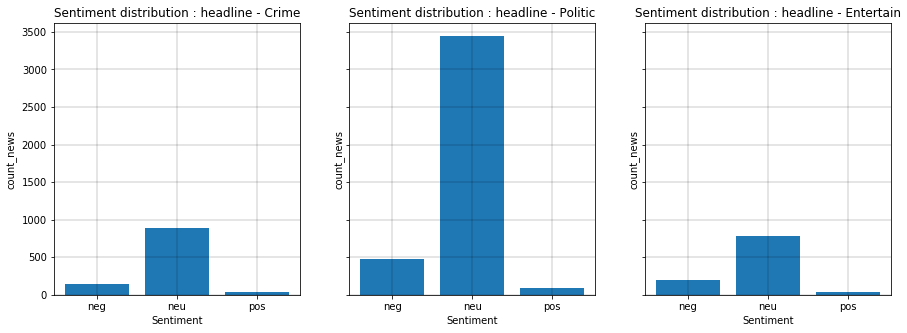

In [43]:
plotSentiment_Dist(output_hl_df, 'headline')

In [44]:
probs_txt = model.predict_proba(X_txt_predict)
output_t_df = pd.DataFrame(probs_txt)
output_t_df.columns = model.classes_
output_t_df["preds"] = model.predict(X_txt_predict)
output_t_df["Category"] = df_plotViz.Category
output_t_df["text"] = df_plotViz.text

In [45]:
output_t_df.head()

,neg,neu,pos,q,preds,Category,text
0,0.111932,0.822675,0.055798,0.009595,neu,Crime,เมื่อวันที่ 7 พ.ย. ที่กองสรรพาวุธ สำนักงานตำรว...
1,0.548378,0.436208,0.002337,0.013076,neg,Crime,เมื่อวันที่ 7 พ.ย. นายสุริยัณห์ หงษ์วิไล โฆษกศ...
2,0.651108,0.211117,0.121043,0.016733,neg,Crime,เมื่อวันที่ 7 พ.ย. ที่สำนักงานตำรวจแห่งชาติ (ต...
3,0.450406,0.497397,0.007268,0.044929,neu,Crime,เมื่อวันที่ 7 พ.ย. ที่ กองบังคับการปราบปราม (บ...
4,0.823583,0.157964,0.014450,0.004003,neg,Crime,เมื่อวันที่ 7 พ.ย. ที่ กองบังคับการปราบปราม (บ...


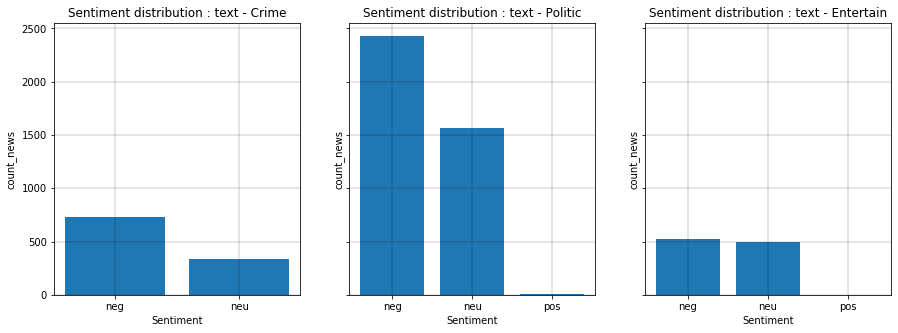

In [46]:
plotSentiment_Dist(output_t_df, 'text')

In [47]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["BADS7101"]
sentiment_db = mydb["SENTIMENT_ALL_NEWS"]

In [48]:
output_t_df['content_type'] = 'text'
output_hl_df['content_type'] = 'headline'
df_sentiment = pd.concat([output_t_df,output_hl_df],ignore_index=True)

In [49]:
df_sentiment.tail()

,neg,neu,pos,q,preds,Category,text,content_type,headline
12189,0.283548,0.521601,0.186007,0.008844,neu,Entertain,NaN,headline,น้ำใจ'เปา กิ่งกาญจน์'แม้ไม่ว่าง ยังช่วย'เบ บอล...
12190,0.134684,0.793843,0.052128,0.019346,neu,Entertain,NaN,headline,ค่าย'เจนนี่'เลือดไหลไม่หยุด 'เบบอล'โบกมือลาอีกคน
12191,0.316245,0.392428,0.280921,0.010406,neu,Entertain,NaN,headline,'ซาร่า'เคลื่อนไหวแล้ว ปมคุณแม่เลี้ยงเดี่ยวป่อง...
12192,0.601367,0.290719,0.104946,0.002968,neg,Entertain,NaN,headline,'เนเงิน'ขนเด็กในค่ายทำคลิป ลงTiktokตอกกลับคำดูถูก
12193,0.570332,0.363118,0.064744,0.001806,neg,Entertain,NaN,headline,BNK48เปิดตัวจัดเต็ม เธียร์เตอร์สเตจใหม่-สุดคุ้...


In [50]:
sentiment_db.delete_many({})
process_data = create_ListofDict_InsertMany(df_sentiment)
sentiment_db.insert_many(process_data)